# Machine Learning - Practical 3 - Multiclass Logistic Regression, MLP and CNNs


Names: {YOUR NAMES}  
Summer Term 2023   
Due Date: Tuesday, May 30, 2pm

**Please note that this practical requires training a lot of models, which may be time consuming (~2h)**

In this practical we will implement multiclass classification with classic Logistic Regression, Multilayer Preceptron, and the convolutional neural network LeNet5 on image data. We will compare the performance of these models. You will work on the following:

 1. Imports and Hardware check
 2. Loading data and related transformations 
 3. Defining training helper functions and metrics 
 4. Logistic Regression 
 5. MLP
 6. CNN
 7. Comparison of results across models

We'll be storing all the losses and accuracies while training, and plotting everything in the end. Use `tqdm` to keep track of your training and validation losses and accuracies since we're only plotting them in the end.

In [73]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

torch.manual_seed(42) # Set manual seed

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [52]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Define data transformations

We will work with the CIFAR-10 dataset, an established computer vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The goal of this dataset is to predict the image class.

Note: The constants in `transforms.Normalize()` are the means and standard deviations of the three color channels of the images in the CIFAR-10 training set. You can verify these numbers yourself by re-computing them.

In [53]:
batch_size = 256

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [54]:
# Load the data and transform the dataset
train_dataset =  datasets.CIFAR10(root='./data', train=True, download=True, transform= train_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform= test_transforms)



# You can verify the mean and standard deviation used in the normalization above by calculating the mean and std of the training dataset above.


Files already downloaded and verified
Files already downloaded and verified


In [55]:
# TODO: make dataloaders (from torch.utils) from datasets, define batch size and do not forget shuffling 
train_loader = DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle = True)


 

In [10]:
## TODO: plot images with their labels after augmentations
def show_batch(dl):
    ## TODO: 
    x,y = next(iter(dl))
    grid_img = torchvision.utils.make_grid(x , nrow=10)
    plt.imshow(grid_img.permute(1, 2, 0))
    

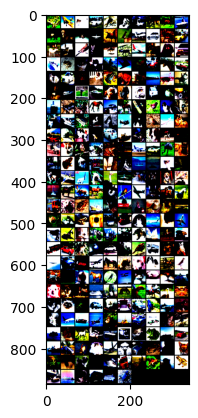

In [11]:
show_batch(train_loader)

In [56]:
num_classes = 10

## Define helper functions for training and metrics

You will need these again and again. 

In [57]:
## TODO: write a function that calculates the accuracy

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    ratio = 100 * (correct.item())/total 
    return ratio

In [58]:
## TODO: Define a train and validation functions here
## Hint - you can use yours from Practical 2 



def train(dataloader, optimizer, model, loss_function):
    """ method to train the model """

    # TODO: refine the training function from above
  # it should contain:
  # - saving of losses
  # - calculation of accuracy
  # - returning the mean loss and accuracy
    losses = []
    model.train()
    sum_loss = 0.0
    total = 0
    correct = 0
    
    
    for i, (x,y) in enumerate(dataloader):
        x= x.to(device)
        y = y.to(device)
                        
        optimizer.zero_grad()
        
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data,1)
        

        # Compute loss
        loss = loss_function(torch.squeeze(y_pred), y)
        

        # Backward pass -> calculate gradients, update weights
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        total += y.size(0)
        sum_loss += loss.item()
        correct += (predicted == y).sum()
    
    n = len(losses)
    mean_loss= sum_loss/n
    acc = accuracy(correct, total)
    
    return mean_loss, acc


def validate(dataloader, model, loss_fn, device):
    """ method to compute the metrics on the validation set """
    # TODO: write a validation function that calculates the loss and accuracy on the validation set
    # you can also combine it with the training function
    model.eval()  # Set the model in evaluation mode
    val_loss = 0.0
    correct = 0
    total=0
    
    with torch.no_grad():
        for i, (x_val, y_val) in enumerate(dataloader):
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            y_pred_val = model(x_val)
            _, predicted = torch.max(y_pred_val.data,1)
            loss_val = loss_function(y_pred_val.squeeze(), y_val)     

            val_loss += loss_val.item()
            total += y_val.size(0)
            correct += ( predicted == y_val).sum()

        val_loss /= len(dataloader)
        acc = accuracy(correct, total)
    
    return val_loss, acc
    
    

In [59]:
#TODO: write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from Practical 2 
from tqdm import tqdm


def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, test_dataloader):
    """ method to run the training procedure """
    # TODO: write a run_training function that 
  # - calls the train and validate functions for each epoch
  # - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
    train_losses=[]
    val_losses = []
    train_accs = []
    val_accs = []
    for epoch in tqdm(range(int(num_epochs)), desc = 'Training Epochs'):
        train_loss=train(train_dataloader, optimizer, model, loss_function)[0]
        train_acc= train(train_dataloader, optimizer, model, loss_function)[1]
        val_loss = validate(test_dataloader,model,loss_function,device)[0]
        val_acc= validate(test_dataloader,model,loss_function,device)[1]
            
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, train_loss, train_acc))
        
    return train_losses, val_losses, train_accs, val_accs
        

In [112]:
# TODO: write a function to calculate and return the confusion values
def calc_confusion_values(dataloader, model, device):
    """ method to compute the confusion values on the validation set """
    model.eval()
    y_pred = []
    y_true = []
    for x,y in dataloader:
        x = x.to(device)
        y= y.to(device)
        output = model(x)
        _, predicted = torch.max(output,1)
        y_pred.extend(predicted.data.cpu().numpy())
        labels = y.data.cpu().numpy()
        y_true.extend(labels)
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    cf_matrix= confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                 columns = [i for i in classes])
    
    
    return plt.figure(figsize = (12,7)), sn.heatmap(df_cm, annot=True)

    

## Logistic Regression   

In [61]:
class LR(torch.nn.Module):
    """
    Logistic regression model inherits from the torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        # TODO: define linear layer for the model
        self.linear = nn.Linear(input_dim, output_dim)
        

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        # TODO: flatten the input to a suitable size for the initial layer
        x = x.view(xb.size(0), -1)
        # TODO: run the data through the layer
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [62]:
## TODO: Define network in the variable named 'linear_regression', put it to the device and train mode
input_dim=32*32*3
output_dim = 10
linear_regression = LR(input_dim, output_dim)
linear_regression.to(device)
linear_regression.train()


LR(
  (linear): Linear(in_features=3072, out_features=10, bias=True)
)

In [63]:
## Optimiser defined. We're going to use Adam since it's always the safe bet, and also for faster convergence. 
optimizer = torch.optim.Adam(linear_regression.parameters(), lr=0.001)

### Define loss 

Since we're dealing with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in \[0, 1\] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.

Hint: Due to numerical reasons, softmax and cross entropy are combined into one operation. Read more about it in https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [64]:
# TODO: define the loss function
loss_function = nn.CrossEntropyLoss()

In [65]:
num_epochs = 20
## TODO: run training over 20 epochs
tl_log, vl_log, ta_log, va_log= run_training(linear_regression, optimizer,loss_function,device, num_epochs, train_loader, test_loader)
        
        
    
    


Training Epochs:   5%|▌         | 1/20 [00:33<10:42, 33.80s/it]

Epoch: 0. Loss: 2.059051772161406. Accuracy: 35.676


Training Epochs:  10%|█         | 2/20 [01:07<10:10, 33.90s/it]

Epoch: 1. Loss: 2.0127250199415245. Accuracy: 36.852


Training Epochs:  15%|█▌        | 3/20 [01:41<09:37, 33.96s/it]

Epoch: 2. Loss: 2.0001349199791343. Accuracy: 37.382


Training Epochs:  20%|██        | 4/20 [02:15<09:03, 33.97s/it]

Epoch: 3. Loss: 1.9924574901863021. Accuracy: 37.656


Training Epochs:  25%|██▌       | 5/20 [02:49<08:28, 33.92s/it]

Epoch: 4. Loss: 1.9852098001509297. Accuracy: 38.09


Training Epochs:  30%|███       | 6/20 [03:24<07:57, 34.11s/it]

Epoch: 5. Loss: 1.9796544672275076. Accuracy: 38.416


Training Epochs:  35%|███▌      | 7/20 [03:58<07:23, 34.08s/it]

Epoch: 6. Loss: 1.9745688262034435. Accuracy: 38.35


Training Epochs:  40%|████      | 8/20 [04:32<06:48, 34.06s/it]

Epoch: 7. Loss: 1.971036738887125. Accuracy: 38.302


Training Epochs:  45%|████▌     | 9/20 [05:06<06:14, 34.09s/it]

Epoch: 8. Loss: 1.9685008805625293. Accuracy: 38.81


Training Epochs:  50%|█████     | 10/20 [05:40<05:40, 34.09s/it]

Epoch: 9. Loss: 1.964651640580625. Accuracy: 39.084


Training Epochs:  55%|█████▌    | 11/20 [06:14<05:06, 34.07s/it]

Epoch: 10. Loss: 1.964728986730381. Accuracy: 38.912


Training Epochs:  60%|██████    | 12/20 [06:48<04:33, 34.21s/it]

Epoch: 11. Loss: 1.9599907483373369. Accuracy: 38.972


Training Epochs:  65%|██████▌   | 13/20 [07:23<03:59, 34.27s/it]

Epoch: 12. Loss: 1.9580664774593042. Accuracy: 38.866


Training Epochs:  70%|███████   | 14/20 [07:57<03:25, 34.25s/it]

Epoch: 13. Loss: 1.9555589295163447. Accuracy: 38.988


Training Epochs:  75%|███████▌  | 15/20 [08:31<02:51, 34.27s/it]

Epoch: 14. Loss: 1.9535454499478242. Accuracy: 38.99


Training Epochs:  80%|████████  | 16/20 [09:06<02:17, 34.31s/it]

Epoch: 15. Loss: 1.9520325630295032. Accuracy: 39.086


Training Epochs:  85%|████████▌ | 17/20 [09:40<01:42, 34.33s/it]

Epoch: 16. Loss: 1.950038912344952. Accuracy: 39.098


Training Epochs:  90%|█████████ | 18/20 [10:15<01:09, 34.53s/it]

Epoch: 17. Loss: 1.95015244155514. Accuracy: 39.166


Training Epochs:  95%|█████████▌| 19/20 [10:49<00:34, 34.40s/it]

Epoch: 18. Loss: 1.9477722133908952. Accuracy: 38.96


Training Epochs: 100%|██████████| 20/20 [11:23<00:00, 34.19s/it]

Epoch: 19. Loss: 1.9469599590009572. Accuracy: 39.05


## Multilayer Perceptron

MLP is a network which consists of several linear fully-connected layers with non-linearities between them.

### Question:
Why are non-linearities between linear layers important?
Otherwise we only have linear sepereation boundaries and only linear seperable problems could be solved.
universal approximation theorem states, that there must be non_linear activation functions.

In [79]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        ## TODO: Make the 4 layer MLP with the following shapes :
        ## input_dim -> 1650 -> 512 -> 138 -> output_dim
        ## Use RELu as nonlinearity

        super(MLP, self).__init__()
        self.l1 = nn.Linear(input_dim, 1650)
        self.l2 = nn.Linear(1650, 512)
        self.l3= nn.Linear(512, 138)
        self.l4 = nn.Linear(138, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, xb):
        ## TODO: write the forward pass
        ## Do not forget to flatten the input
        #m = nn.Flatten()
        xb = xb.view(xb.size(0), -1)
        
        out = self.l1(xb)
        out= self.relu(out)
        out= self.l2(out)
        out= self.relu(out)
        out= self.l3(out)
        out= self.relu(out)
        out=self.l4(out)
        
        
        return out 

In [70]:
## TODO: Define network, put it to device and train mode
model = MLP(input_dim, output_dim)
model.to(device)
model.train()


MLP(
  (l1): Linear(in_features=3072, out_features=1650, bias=True)
  (l2): Linear(in_features=1650, out_features=512, bias=True)
  (l3): Linear(in_features=512, out_features=138, bias=True)
  (l4): Linear(in_features=138, out_features=10, bias=True)
  (relu): ReLU()
)

In [71]:
## TODO: Define optimizer and loss functions
loss_function = nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr= 0.001)

In [72]:
## TODO: Train the MLP over 20 epochs
epochs = 20
tl_mlp, vl_mlp, ta_mlp, va_mlp= run_training(model,optimizer,loss_function,device,epochs,train_loader, test_loader)
        


Training Epochs:   5%|▌         | 1/20 [00:35<11:21, 35.86s/it]

Epoch: 0. Loss: 1.665177623228151. Accuracy: 48.422


Training Epochs:  10%|█         | 2/20 [01:11<10:43, 35.75s/it]

Epoch: 1. Loss: 1.3680717032782885. Accuracy: 54.264


Training Epochs:  15%|█▌        | 3/20 [01:47<10:09, 35.86s/it]

Epoch: 2. Loss: 1.2300452510921323. Accuracy: 58.578


Training Epochs:  20%|██        | 4/20 [02:23<09:34, 35.91s/it]

Epoch: 3. Loss: 1.130721282594058. Accuracy: 61.884


Training Epochs:  25%|██▌       | 5/20 [02:59<08:58, 35.90s/it]

Epoch: 4. Loss: 1.0327194880466073. Accuracy: 64.806


Training Epochs:  30%|███       | 6/20 [03:35<08:21, 35.81s/it]

Epoch: 5. Loss: 0.9499729026337059. Accuracy: 67.368


Training Epochs:  35%|███▌      | 7/20 [04:11<07:46, 35.88s/it]

Epoch: 6. Loss: 0.8666460699572855. Accuracy: 70.354


Training Epochs:  40%|████      | 8/20 [04:46<07:08, 35.75s/it]

Epoch: 7. Loss: 0.7942066651826002. Accuracy: 72.806


Training Epochs:  45%|████▌     | 9/20 [05:22<06:33, 35.76s/it]

Epoch: 8. Loss: 0.7230789868199096. Accuracy: 75.154


Training Epochs:  50%|█████     | 10/20 [05:58<05:57, 35.78s/it]

Epoch: 9. Loss: 0.6647411676085725. Accuracy: 77.77


Training Epochs:  55%|█████▌    | 11/20 [06:33<05:21, 35.74s/it]

Epoch: 10. Loss: 0.5941792717393564. Accuracy: 79.338


Training Epochs:  60%|██████    | 12/20 [07:09<04:45, 35.64s/it]

Epoch: 11. Loss: 0.5462860232409166. Accuracy: 81.19


Training Epochs:  65%|██████▌   | 13/20 [07:44<04:09, 35.67s/it]

Epoch: 12. Loss: 0.5076831737343146. Accuracy: 83.146


Training Epochs:  70%|███████   | 14/20 [08:22<03:37, 36.19s/it]

Epoch: 13. Loss: 0.45835250190326143. Accuracy: 84.346


Training Epochs:  75%|███████▌  | 15/20 [08:57<02:59, 35.95s/it]

Epoch: 14. Loss: 0.4262992656048463. Accuracy: 85.246


Training Epochs:  80%|████████  | 16/20 [09:34<02:24, 36.10s/it]

Epoch: 15. Loss: 0.3891745939546702. Accuracy: 86.452


Training Epochs:  85%|████████▌ | 17/20 [10:10<01:48, 36.13s/it]

Epoch: 16. Loss: 0.3700869060596641. Accuracy: 87.21


Training Epochs:  90%|█████████ | 18/20 [10:46<01:12, 36.18s/it]

Epoch: 17. Loss: 0.34343205323936987. Accuracy: 88.248


Training Epochs:  95%|█████████▌| 19/20 [11:23<00:36, 36.23s/it]

Epoch: 18. Loss: 0.3239276502661559. Accuracy: 89.102


Training Epochs: 100%|██████████| 20/20 [12:00<00:00, 36.02s/it]

Epoch: 19. Loss: 0.3074660127108194. Accuracy: 89.764


## Add L2 regularisation

In [80]:
# TODO: Define new model, optimizer, put model to device, etc.
## 0.0005 is a good starting point for the regularization strength
model_l2 = MLP(input_dim, output_dim)
optimizer_l2 = torch.optim.Adam(model_l2.parameters(), lr= 0.001, weight_decay=1e-5)
model_l2.to(device)
model_l2.train()

MLP(
  (l1): Linear(in_features=3072, out_features=1650, bias=True)
  (l2): Linear(in_features=1650, out_features=512, bias=True)
  (l3): Linear(in_features=512, out_features=138, bias=True)
  (l4): Linear(in_features=138, out_features=10, bias=True)
  (relu): ReLU()
)

In [81]:
## TODO: Retrain new model with regularization over 20 epochs
epochs = 20
tl_L2, vl_L2, ta_L2, va_L2= run_training(model_l2,optimizer_l2,loss_function,device,epochs,train_loader, test_loader)


Training Epochs:   5%|▌         | 1/20 [00:35<11:21, 35.86s/it]

Epoch: 0. Loss: 1.6749189404808744. Accuracy: 48.17


Training Epochs:  10%|█         | 2/20 [01:11<10:43, 35.74s/it]

Epoch: 1. Loss: 1.3626750786693729. Accuracy: 54.29


Training Epochs:  15%|█▌        | 3/20 [01:48<10:20, 36.50s/it]

Epoch: 2. Loss: 1.2379503821840092. Accuracy: 58.018


Training Epochs:  20%|██        | 4/20 [02:25<09:44, 36.54s/it]

Epoch: 3. Loss: 1.1354093220160932. Accuracy: 61.108


Training Epochs:  25%|██▌       | 5/20 [03:02<09:11, 36.78s/it]

Epoch: 4. Loss: 1.0541450816149613. Accuracy: 63.762


Training Epochs:  30%|███       | 6/20 [03:38<08:29, 36.39s/it]

Epoch: 5. Loss: 0.9697219954461468. Accuracy: 66.426


Training Epochs:  35%|███▌      | 7/20 [04:16<07:59, 36.90s/it]

Epoch: 6. Loss: 0.901379683492135. Accuracy: 69.172


Training Epochs:  40%|████      | 8/20 [04:51<07:17, 36.45s/it]

Epoch: 7. Loss: 0.8321160981241538. Accuracy: 71.472


Training Epochs:  45%|████▌     | 9/20 [05:27<06:37, 36.14s/it]

Epoch: 8. Loss: 0.7705196917665248. Accuracy: 73.634


Training Epochs:  50%|█████     | 10/20 [06:03<06:00, 36.03s/it]

Epoch: 9. Loss: 0.7071405393736703. Accuracy: 75.658


Training Epochs:  55%|█████▌    | 11/20 [06:38<05:23, 35.94s/it]

Epoch: 10. Loss: 0.6526351419030404. Accuracy: 77.16


Training Epochs:  60%|██████    | 12/20 [07:14<04:46, 35.79s/it]

Epoch: 11. Loss: 0.6078112567869984. Accuracy: 78.964


Training Epochs:  65%|██████▌   | 13/20 [07:49<04:09, 35.71s/it]

Epoch: 12. Loss: 0.5680758487813327. Accuracy: 80.958


Training Epochs:  70%|███████   | 14/20 [08:25<03:34, 35.73s/it]

Epoch: 13. Loss: 0.5227641130284387. Accuracy: 81.836


Training Epochs:  75%|███████▌  | 15/20 [09:00<02:58, 35.64s/it]

Epoch: 14. Loss: 0.4775717915320883. Accuracy: 82.76


Training Epochs:  80%|████████  | 16/20 [09:36<02:22, 35.57s/it]

Epoch: 15. Loss: 0.46239032459502316. Accuracy: 84.172


Training Epochs:  85%|████████▌ | 17/20 [10:11<01:46, 35.50s/it]

Epoch: 16. Loss: 0.4259338651080521. Accuracy: 84.604


Training Epochs:  90%|█████████ | 18/20 [10:47<01:11, 35.57s/it]

Epoch: 17. Loss: 0.3895466869734988. Accuracy: 86.326


Training Epochs:  95%|█████████▌| 19/20 [11:22<00:35, 35.48s/it]

Epoch: 18. Loss: 0.3926609328054652. Accuracy: 86.52


Training Epochs: 100%|██████████| 20/20 [11:58<00:00, 35.91s/it]

Epoch: 19. Loss: 0.367070983867256. Accuracy: 87.616


## LeNet5

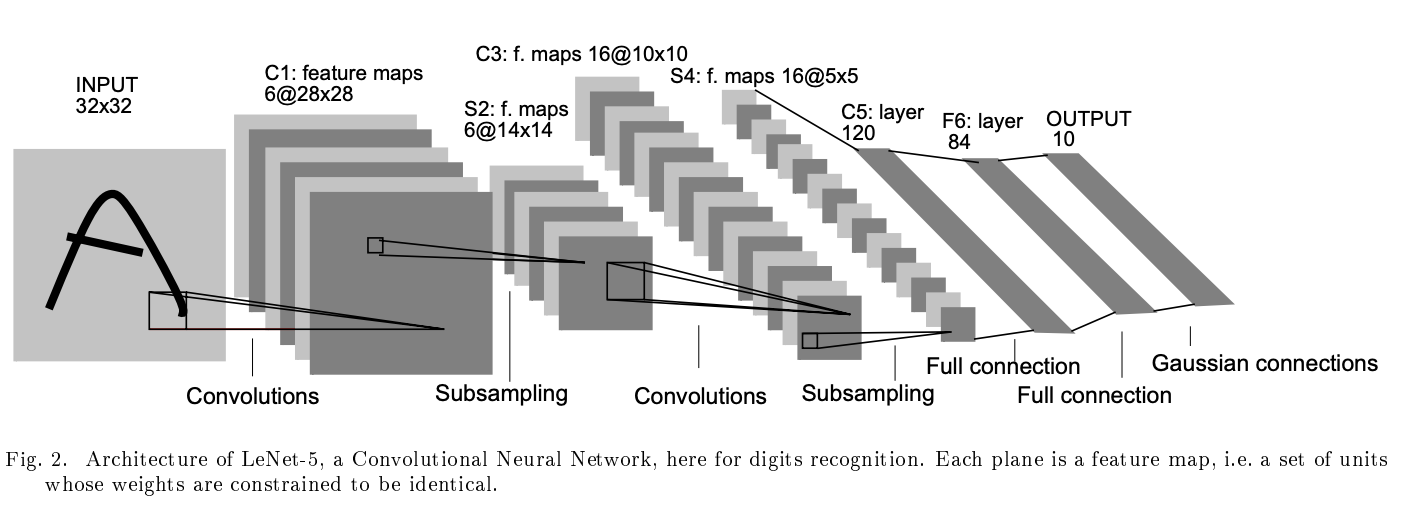

Let's implememt one of the classical convolutional network and apply it for CIFA10. Here is the link for the [original paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) of LeNet5 introduced by Yann LeCun and colleagues in 1998. The original implentation of LeNet5 has Tanh as non-linearities. In 2012, AlexNet famously set off the deep learning revolution. AlexNet is based on LeNet, with two main innovations: (1) making it deeper by adding a few extra layers and (2) replacing the tanh activation functions by ReLU to improve training. Here we'll the original LeNet5 architecture to keep the compute requirements small, but work with the more modern ReLU activation functions.

One more thing we change in the original network is the number of input channels as LeNet5 was designed for grayscale MNIST dataset, where each picture has 1 channel, while for RGB pictures we have 3 channels in the input data.


In [84]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, in_channels=3):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            ## TODO: add remaining layers, pooling and nonlinearities up to layer C5
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2),
            
            
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, n_classes)
            
    
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [88]:
## TODO: define network, put it to the device and train mode
model_LE = LeNet5(10)
model_LE.to(device)
model_LE.train()


LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [90]:
## TODO: define loss function and optimisers
optimizer_LE = torch.optim.Adam(model_LE.parameters(), lr= 0.001)
loss_function = loss_function

In [91]:
## TODO: train with 20 epochs
num_epochs = 20
tl_LE, vl_LE, ta_LE, va_LE= run_training(model_LE, optimizer_LE, loss_function, device, num_epochs, train_loader, test_loader)

Training Epochs:   5%|▌         | 1/20 [00:35<11:16, 35.63s/it]

Epoch: 0. Loss: 1.8405693209901148. Accuracy: 44.084


Training Epochs:  10%|█         | 2/20 [01:11<10:42, 35.67s/it]

Epoch: 1. Loss: 1.4443647198531093. Accuracy: 50.726


Training Epochs:  15%|█▌        | 3/20 [01:47<10:07, 35.73s/it]

Epoch: 2. Loss: 1.320124468024896. Accuracy: 53.836


Training Epochs:  20%|██        | 4/20 [02:23<09:37, 36.09s/it]

Epoch: 3. Loss: 1.2416767709109249. Accuracy: 56.64


Training Epochs:  25%|██▌       | 5/20 [02:59<09:01, 36.09s/it]

Epoch: 4. Loss: 1.1842824536926893. Accuracy: 58.67


Training Epochs:  30%|███       | 6/20 [03:35<08:23, 35.94s/it]

Epoch: 5. Loss: 1.132454153834557. Accuracy: 60.438


Training Epochs:  35%|███▌      | 7/20 [04:11<07:45, 35.84s/it]

Epoch: 6. Loss: 1.0928767642804555. Accuracy: 62.022


Training Epochs:  40%|████      | 8/20 [04:46<07:08, 35.72s/it]

Epoch: 7. Loss: 1.056463927638774. Accuracy: 62.95


Training Epochs:  45%|████▌     | 9/20 [05:22<06:31, 35.63s/it]

Epoch: 8. Loss: 1.0250193078298957. Accuracy: 64.308


Training Epochs:  50%|█████     | 10/20 [05:57<05:56, 35.67s/it]

Epoch: 9. Loss: 0.9962829999169525. Accuracy: 65.388


Training Epochs:  55%|█████▌    | 11/20 [06:33<05:22, 35.83s/it]

Epoch: 10. Loss: 0.9671051514391996. Accuracy: 66.154


Training Epochs:  60%|██████    | 12/20 [07:10<04:47, 35.91s/it]

Epoch: 11. Loss: 0.9372381458477098. Accuracy: 67.084


Training Epochs:  65%|██████▌   | 13/20 [07:46<04:11, 35.99s/it]

Epoch: 12. Loss: 0.9232518368837784. Accuracy: 67.874


Training Epochs:  70%|███████   | 14/20 [08:22<03:36, 36.06s/it]

Epoch: 13. Loss: 0.9018825405106252. Accuracy: 68.694


Training Epochs:  75%|███████▌  | 15/20 [08:58<03:00, 36.01s/it]

Epoch: 14. Loss: 0.8790984500427635. Accuracy: 69.256


Training Epochs:  80%|████████  | 16/20 [09:33<02:23, 35.84s/it]

Epoch: 15. Loss: 0.8627616109288468. Accuracy: 69.742


Training Epochs:  85%|████████▌ | 17/20 [10:09<01:47, 35.73s/it]

Epoch: 16. Loss: 0.8463374975384498. Accuracy: 70.428


Training Epochs:  90%|█████████ | 18/20 [10:45<01:11, 35.93s/it]

Epoch: 17. Loss: 0.8361796639403518. Accuracy: 71.05


Training Epochs:  95%|█████████▌| 19/20 [11:21<00:35, 35.93s/it]

Epoch: 18. Loss: 0.8119309286073763. Accuracy: 71.218


Training Epochs: 100%|██████████| 20/20 [11:57<00:00, 35.89s/it]

Epoch: 19. Loss: 0.8030748488951702. Accuracy: 71.854


## Analysis 

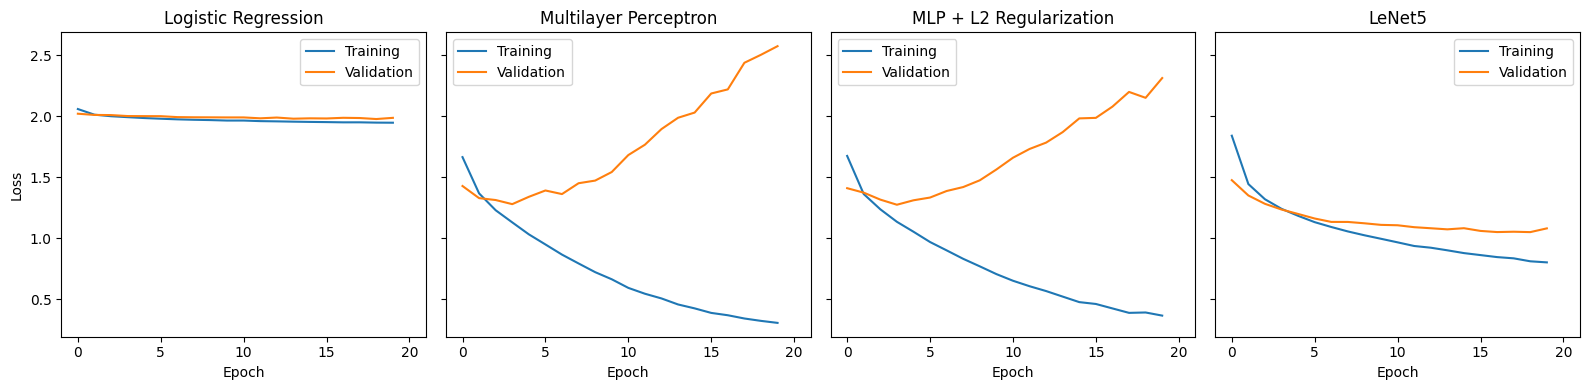

In [93]:
## TODO: Plot both train and val losses for all models. 
## What do you see?
fig, axs = plt.subplots(1,4, sharey=True, figsize=(16,4), tight_layout=True)

axs[0].set_ylabel("Loss")
axs[0].set_title("Logistic Regression")
axs[0].plot(tl_log, label="Training")
axs[0].plot(vl_log, label="Validation")

axs[0].set_ylabel("Loss")
axs[1].set_title("Multilayer Perceptron")
axs[1].plot(tl_mlp, label="Training")
axs[1].plot(vl_mlp, label="Validation")

axs[0].set_ylabel("Loss")
axs[2].set_title("MLP + L2 Regularization")
axs[2].plot(tl_L2, label="Training")
axs[2].plot(vl_L2, label="Validation")

axs[0].set_ylabel("Loss")
axs[3].set_title("LeNet5")
axs[3].plot(tl_LE, label="Training")
axs[3].plot(vl_LE, label="Validation")

for ax in axs:
    ax.set_xlabel("Epoch")
    ax.set_xlim([-1,num_epochs+1])
    ax.set_xticks([0,5,10,15,20])
    ax.legend()

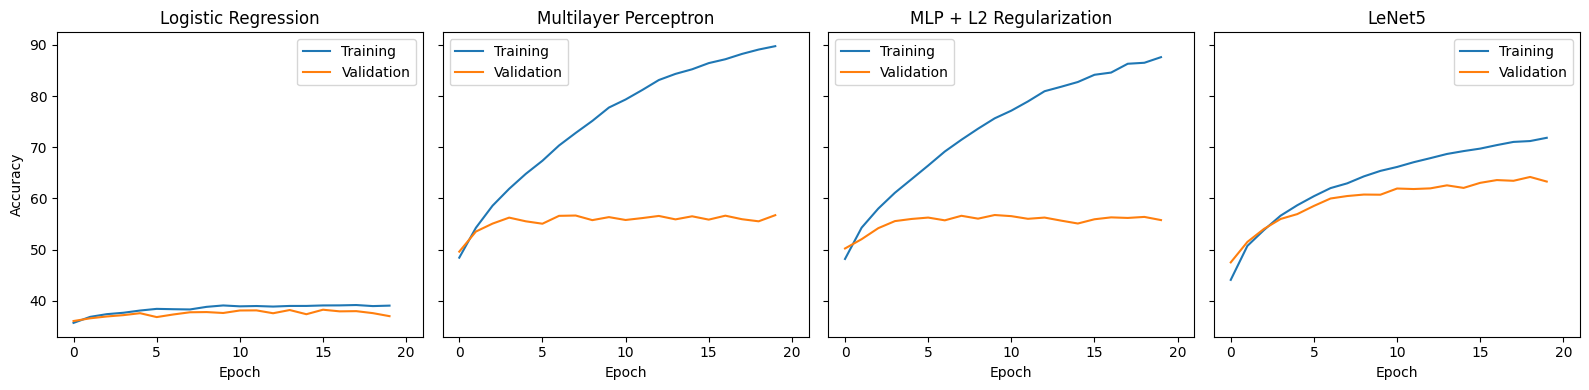

In [97]:
## TODO: Plot both train and val accuracies for all models. 
## What do you see?
fig, axs = plt.subplots(1,4, sharey=True, figsize=(16,4), tight_layout=True)

axs[0].set_ylabel("Accuracy")
axs[0].set_title("Logistic Regression")
axs[0].plot(ta_log, label="Training")
axs[0].plot(va_log, label="Validation")

axs[0].set_ylabel("Accuracy")
axs[1].set_title("Multilayer Perceptron")
axs[1].plot(ta_mlp, label="Training")
axs[1].plot(va_mlp, label="Validation")

axs[0].set_ylabel("Accuracy")
axs[2].set_title("MLP + L2 Regularization")
axs[2].plot(ta_L2, label="Training")
axs[2].plot(va_L2, label="Validation")

axs[0].set_ylabel("Accuracy")
axs[3].set_title("LeNet5")
axs[3].plot(ta_LE, label="Training")
axs[3].plot(va_LE, label="Validation")

for ax in axs:
    ax.set_xlabel("Epoch")
    ax.set_xlim([-1,num_epochs+1])
    ax.set_xticks([0,5,10,15,20])
    ax.legend()

(<Figure size 1200x700 with 2 Axes>, <AxesSubplot: >)

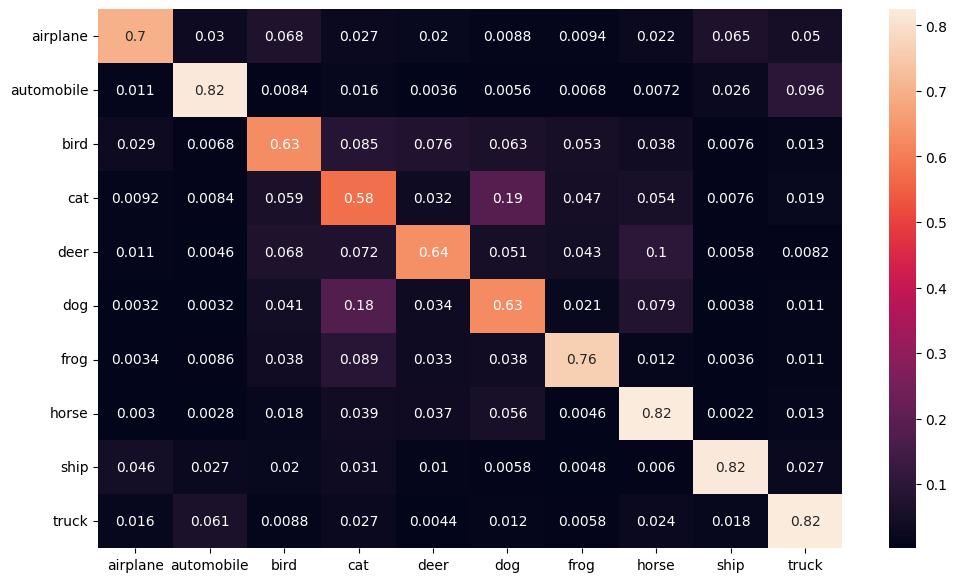

In [113]:
## TODO: Plot the confusion matrix for LeNet5
calc_confusion_values(train_loader, model_LE, device)



## Questions
* How did regularization change the performance of the MLP? Why?
A bit less overfitting due to regularization, the validation loss is not as high, as without.
* Explain the confusion matrix for LeNet5. What do you see there?
Gives (in this case the percentage) of correct classified images and the wrongly classified images. For example the networrk recognizes triucks and
well and has a hard time identifying cats.
* Explain the difference in peformance between linear regression, MLP, and LeNet5.
linear regression models linear boundaries, MLP has boundaries that are not linear and LeNET5 further adds convolutional filters (so very often the images then have a smaller size) and adds max pooling. 
* Why are convolutions better suited for pictures? Which properties of images do they exploit?
Reduces high dimensionlity
* Is it important to redefine an optimizer for each different model, training? What about loss functions?


## Additional experiments (Optional)
* Try to replace CIFAR10 dataset with MNIST. What do you notice? Why? Try to explain the differences in terms of variance or dataset complexity
